# Xopt basic example

An Xopt problem can be described by a simple YAML file. Here we will demonstrate how this is used to optimize a well-known constrained multi-objective test function, TNK. The TNK function is defined with:

$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# Import the class
from xopt import Xopt

In [2]:
# Nicer plotting
%config InlineBackend.figure_format = 'retina'

## Xopt Components
The definition of the Xopt object requires 4 parts, listed below:
- The `Xopt` object itself, which controlls data flow, stores data and governs data
loading and saving.
- The `Evaluator` object, which evaluates input points using the arbitrary function
specified by the `function` property.
- The `Generator` object, which, when given data that has been evaluated, generates
future points to evaluate using the evaluator.
- The `VOCS` (variables, objectives, constraints, statics) object, which specifies the
input domain, the objectives, constraints and constants passed to the evaluator
function.

Through the YAML interface these objects and their options are specified by name. 
Here we will make one:

In [3]:
# Make a proper input file.
YAML = """
xopt: {}
evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK
    function_kwargs:
        a: 999

generator:
    name: random

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE, y2: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""

In [4]:
# create Xopt object.
X = Xopt(YAML)

In [5]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 0+untagged.1.ga416c11
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: null, max_evaluations: null}
generator: {name: random}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0, a: 999}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constants: {a: dummy_constant}
  observables: []


In [6]:
X.random_evaluate(10)

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.038335,2.844667,dummy_constant,1.038335,2.844667,8.092727,5.787267,"[1, 2, 3]",0.000067,False
2,1.350118,1.242715,dummy_constant,1.350118,1.242715,2.288307,1.274326,"[1, 2, 3]",0.000015,False
3,2.668601,2.992497,dummy_constant,2.668601,2.992497,15.015444,10.915371,"[1, 2, 3]",0.000012,False
4,1.184648,0.879935,dummy_constant,1.184648,0.879935,1.247557,0.613093,"[1, 2, 3]",0.000011,False
5,2.317726,1.209369,dummy_constant,2.317726,1.209369,5.818582,3.807333,"[1, 2, 3]",0.000015,False
6,0.345366,2.185975,dummy_constant,0.345366,2.185975,3.978303,2.866422,"[1, 2, 3]",0.000011,False
7,1.071747,2.935168,dummy_constant,1.071747,2.935168,8.686195,6.256937,"[1, 2, 3]",0.000011,False
8,2.287761,0.585298,dummy_constant,2.287761,0.585298,4.641223,3.203366,"[1, 2, 3]",0.000011,False
9,1.605880,0.018062,dummy_constant,1.605880,0.018062,1.480791,1.455235,"[1, 2, 3]",0.000011,False
10,2.004435,0.059163,dummy_constant,2.004435,0.059163,2.932199,2.457661,"[1, 2, 3]",0.000011,False


## Run Random data generation

In [7]:
import numpy as np
np.random.seed(10)

In [8]:
# Take one step (generate a single point)
X.step()

In [9]:
# examine the results
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.038335,2.844667,dummy_constant,1.038335,2.844667,8.092727,5.787267,"[1, 2, 3]",0.000067,False
2,1.350118,1.242715,dummy_constant,1.350118,1.242715,2.288307,1.274326,"[1, 2, 3]",0.000015,False
3,2.668601,2.992497,dummy_constant,2.668601,2.992497,15.015444,10.915371,"[1, 2, 3]",0.000012,False
4,1.184648,0.879935,dummy_constant,1.184648,0.879935,1.247557,0.613093,"[1, 2, 3]",0.000011,False
5,2.317726,1.209369,dummy_constant,2.317726,1.209369,5.818582,3.807333,"[1, 2, 3]",0.000015,False
6,0.345366,2.185975,dummy_constant,0.345366,2.185975,3.978303,2.866422,"[1, 2, 3]",0.000011,False
7,1.071747,2.935168,dummy_constant,1.071747,2.935168,8.686195,6.256937,"[1, 2, 3]",0.000011,False
8,2.287761,0.585298,dummy_constant,2.287761,0.585298,4.641223,3.203366,"[1, 2, 3]",0.000011,False
9,1.605880,0.018062,dummy_constant,1.605880,0.018062,1.480791,1.455235,"[1, 2, 3]",0.000011,False
10,2.004435,0.059163,dummy_constant,2.004435,0.059163,2.932199,2.457661,"[1, 2, 3]",0.000011,False


In [10]:
# take a couple of steps and examine the results
for _ in range(10):
    X.step()
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.038335,2.844667,dummy_constant,1.038335,2.844667,8.092727,5.787267,"[1, 2, 3]",0.000067,False
2,1.350118,1.242715,dummy_constant,1.350118,1.242715,2.288307,1.274326,"[1, 2, 3]",0.000015,False
3,2.668601,2.992497,dummy_constant,2.668601,2.992497,15.015444,10.915371,"[1, 2, 3]",0.000012,False
4,1.184648,0.879935,dummy_constant,1.184648,0.879935,1.247557,0.613093,"[1, 2, 3]",0.000011,False
5,2.317726,1.209369,dummy_constant,2.317726,1.209369,5.818582,3.807333,"[1, 2, 3]",0.000015,False
6,0.345366,2.185975,dummy_constant,0.345366,2.185975,3.978303,2.866422,"[1, 2, 3]",0.000011,False
7,1.071747,2.935168,dummy_constant,1.071747,2.935168,8.686195,6.256937,"[1, 2, 3]",0.000011,False
8,2.287761,0.585298,dummy_constant,2.287761,0.585298,4.641223,3.203366,"[1, 2, 3]",0.000011,False
9,1.605880,0.018062,dummy_constant,1.605880,0.018062,1.480791,1.455235,"[1, 2, 3]",0.000011,False
10,2.004435,0.059163,dummy_constant,2.004435,0.059163,2.932199,2.457661,"[1, 2, 3]",0.000011,False


## Plotting
Plot the objective results

<Axes: xlabel='y1', ylabel='y2'>

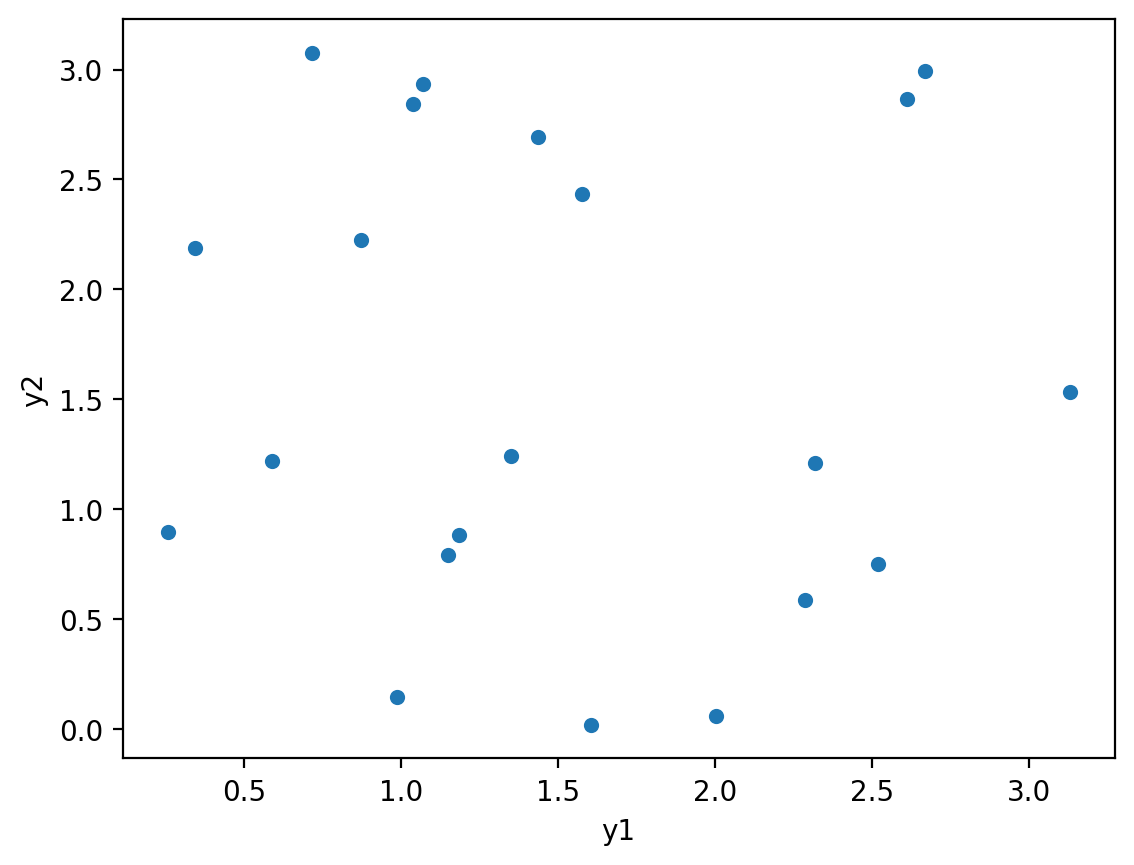

In [11]:
import matplotlib.pyplot as plt

X.data.plot(*X.vocs.objective_names, kind="scatter")

## Alternative initialization methods

For convenience, if the first (and only) positional argument is present, then Xopt will automatically try to load from JSON, YAML str or files, or as a dict.

In [12]:
import yaml
import json

config  = yaml.safe_load(YAML) 
# All these methods work

X = Xopt(YAML)
X = Xopt(config)
X = Xopt(json.dumps(config, indent=4))


## Convenience Methods

In [13]:
# Call the evaluator's function directly.
X.evaluate({'x1': .5, 'x2': 0.5})

{'y1': 0.5,
 'y2': 0.5,
 'c1': -0.6,
 'c2': 0.0,
 'some_array': array([1, 2, 3]),
 'xopt_runtime': 3.320199994050199e-05,
 'xopt_error': False}

In [14]:
# Create random inputs according to the vocs
X.random_inputs()

{'x1': array([1.9687064]), 'x2': array([1.02373858]), 'a': 'dummy_constant'}

In [15]:
# These can be combined:
np.random.seed(10)
X.evaluate(X.random_inputs())

{'y1': array([0.71841678]),
 'y2': array([3.07639588]),
 'c1': array([9.06666383]),
 'c2': array([6.68552164]),
 'some_array': array([1, 2, 3]),
 'xopt_runtime': 3.820200004156504e-05,
 'xopt_error': False}

In [16]:
# And this is a convenience method for above
np.random.seed(10)
X.random_evaluate()

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,0.718417,3.076396,dummy_constant,0.718417,3.076396,9.066664,6.685522,"[1, 2, 3]",0.000038,False


## Logging

Normally Xopt will not issue print statments, and instead issue logging messages. Below will enable these to be seen in the notebook

In [17]:
# Notebook printing output
from xopt import output_notebook
output_notebook()

In [18]:
X.step()

Running Xopt step
